In [5]:
import pandas as pd
from river import stream,tree,metrics
import utils
from encoding import prefix_bin
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import os
from tqdm import tqdm
import sliding_window
import datetime, time
import importlib
importlib.reload(sliding_window)

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

In [6]:
file_name = './data/loan_baseline.pnml_noise_0.15_iteration_1_seed_614_sample.csv'


dataset = stream.iter_csv(
            file_name
#             './data/loan_baseline.pnml_noise_0.15_iteration_1_seed_614_simple.csv',
            )

totallength = len(list(dataset))

In [7]:
dataset = stream.iter_csv(
            file_name,
            drop=['noise', 'lifecycle:transition', 'Variant', 'Variant index'],
            )
enctype = 'Index-base'

In [8]:
key_pair = {
'Case ID':'caseid',
'Activity':'activity',
# 'Resource':'resource',
'Complete Timestamp':'ts',
}
catatars= ['activity']#,'resource']

case_dict ={}
training_models ={}

casecount = 0
rowcounter = 0
resultdict ={}
acc_dict ={}
prefix_wise_window = {}
prediction_result = {}
graceperiod_finish=0
finishedcases = set()

In [9]:
# Sliding window for training setting
window_size = 100
retraining_size = 20
training_window = sliding_window.training_window(window_size,retraining_size)

In [10]:
def display_progress(row_counting, total_length, start_time, interval=500):
    if rowcounter%interval == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running cases: %s'%(len(case_dict)),
             'Elapse time: %s mins'%(round((time.time()-start_time)/60, 3)))

In [11]:
class Customdataset():
    def __init__(self, dataset):
        '''
        Convert dataset to tensor
        
        Params
        dataset_type: Type of dataset, trainset, validset, and testset
        '''
        self.dataset = dataset


    def preprocessing(self):
        self.x_data=self.dataset[0]
        self.y_data=self.dataset[1]

        x = self.x_data.to_numpy()
        x = np.reshape(x, (x.shape[0],1, x.shape[1]))
        y_set = sorted(set(self.y_data))
        train_y =[]
        for y in self.y_data:
            train_y.append(y_set.index(y))

        x_tensor = torch.tensor(x, dtype=torch.float)
        y_tensor = torch.tensor(train_y, dtype=torch.long)

        return x_tensor, y_tensor

    
    def test_preprocessing(self):
        self.x_data=self.dataset

        x = self.x_data.to_numpy()
        x = np.reshape(x, (x.shape[0],1, x.shape[1]))

        x_tensor = torch.tensor(x, dtype=torch.float)

        return x_tensor
      

In [12]:
class LSTM_model(nn.Module): # nn.Module inherit

    def __init__(self, input_x, raw_y):
        super(LSTM_model, self).__init__()
        
        self.input_size = input_x.shape[2]
        self.hidden_size =2* input_x.shape[2]
        self.num_case = 1
        self.num_layers =2

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, dropout=0.25, batch_first =False, bidirectional = False)

        self.h0 = torch.randn(self.num_layers, 1, self.hidden_size)
        self.c0 = torch.randn(self.num_layers, 1, self.hidden_size)

        latent_vector_size =50 * 1
        self.linear1 = nn.Linear(1 *self.num_case *self.hidden_size, latent_vector_size)
        self.linear_h = nn.Linear(1 *self.num_layers *self.hidden_size, latent_vector_size)
        self.linear_o = nn.Linear(3 * latent_vector_size, 1 *self.num_case * len(set(raw_y)))

        self.relu = nn.ReLU()


    def forward(self, input_x):
        output, (hn,cn) = self.lstm(input_x, (self.h0,self.c0))
        output = output.reshape((output.size()[0] *output.size()[1] *output.size()[2]))
        output = self.relu(self.linear1(output))

        uH = F.leaky_relu(self.linear_h(hn.reshape((hn.size()[0] *hn.size()[1] *hn.size()[2]))))
        uC = F.leaky_relu(self.linear_h(cn.reshape((cn.size()[0] *cn.size()[1] *cn.size()[2]))))
        output = torch.cat((uH ,uC ,output))
        output = self.linear_o(output)
        
        output =output.reshape(self.num_case,-1)

        return output

In [13]:
def training_stage(window, training_models):
    '''
    Manage training stage of streaming anomaly detection
    ----------
    Parameters
    window: class training_window
        Sliding window with training data
    training_models: dict
        Trained detector by prefix stored in. Default is randomforest
    ----------
    Return
    training_models
    '''
    pw_window = training_window.prefix_wise_window()
    cross_entropy_loss = torch.nn.CrossEntropyLoss()
    for x in pw_window:
        input_x = pw_window[x][0]
        input_y = pw_window[x][1]
        dataset = pw_window[x]
        train_x,train_y = Customdataset(dataset).preprocessing()
        loss_list =[]

        x_tensor = torch.unsqueeze(train_x[0], dim=0)
        y_tensor = torch.unsqueeze(train_y[0], dim=0)
        model = LSTM_model(x_tensor, input_y)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        optimizer.zero_grad()

        previous_model =0
        for i in range(30):
            running_loss =0
            for pos, x in enumerate(train_x):
                x_tensor = torch.unsqueeze(x, dim=0)
                y_tensor = torch.unsqueeze(train_y[pos], dim=0)

                output = model(x_tensor)
                loss = cross_entropy_loss(output, y_tensor)
                running_loss += loss.item()
                loss.backward()
                optimizer.step()

            if len(loss_list) ==0:
                pass

            else:
                if running_loss > np.mean(loss_list):
                    break

            loss_list.append(running_loss)
            previous_model = model
            
        if 'detector_%s'%(x) not in training_models:
            training_models['detector_%s'%(x)] =[0,0,0]
        training_models['detector_%s'%(x)][0] += 1
        training_models['detector_%s'%(x)][1] = previous_model
        training_models['detector_%s'%(x)][2] = sorted(set(input_y))
    return training_models

In [14]:
def predict_activity_proba(last_event):
    '''
    Predict next activity prediction 
    
    Parameters
    ----------
    last_event: case_bin
    
    Return
    ----------
    modelid, prediction
    
    '''
    feature_matrix = prefix_wise_window['window_%s'%(last_event.prefix_length)][0].columns.values
    current_event = utils.readjustment_training(last_event.encoded, feature_matrix)
    current_event = pd.Series(current_event).to_frame().T
    current_event = Customdataset(current_event).test_preprocessing()
    
    model = training_models['detector_window_%s'%(last_event.prefix_length)][1]
    label_classes = training_models['detector_window_%s'%(last_event.prefix_length)][2]
    test_output = model(current_event)
    prediction = [test_output, label_classes]
    modelid = training_models['detector_window_%s'%(last_event.prefix_length)][0]

    return modelid, prediction

In [15]:
def first_event(case_bin):
    '''
    Generate start event before first event
    '''
    print(case_bin.event['ts'])
    empty_data ={'activity':'Start signal', 'ts':datetime.datetime.strftime(case_bin.event['ts'], '%Y-%m-%d %H:%M:%S')}
    start_event = prefix_bin(case_bin.caseid, empty_data)
    start_event.set_prefix_length(0)
    start_event.update_encoded(catattrs=catatars,enctype=enctype)
    start_event.update_truelabel(case_bin.event['activity'])
    return start_event

In [16]:
start_time = time.time()

for x,y in dataset:
    display_progress(rowcounter, totallength,start_time)
    rowcounter +=1
    
    utils.dictkey_chg(x, key_pair)
    # Event stream change dictionary keys
    x['ts'] = x['ts'][:-4]
    
    # Check label possible
    
    # Initialize case by prefix length
    caseid = x['caseid']
    x.pop('caseid')
    
    case_bin = prefix_bin(caseid, x)
    
    if caseid not in list(case_dict.keys()):
        case_dict[caseid] = []
        case_bin.set_prefix_length(1)
        
    elif caseid in finishedcases:
        continue
    
    else:
        case_bin.set_prefix_length(len(case_dict[caseid])+1)
        case_bin.set_prev_enc(case_dict[caseid][-1])
    
    # Encode event and cases and add to DB
    ts = case_bin.event['ts']
    case_bin.update_encoded(catattrs=catatars,enctype=enctype)
    
    # Set current activity as outcome of previous event
    if case_bin.prefix_length != 1:
        case_bin.prev_enc.update_truelabel(x['activity'])

    # First prediction for current event
    
    last_event = case_bin
    modelid = 'None'
    prediction = 'Not Available'

    if len(training_window.getAllitems()) !=0:
        if 'window_%s'%(last_event.prefix_length) in list(prefix_wise_window.keys()) and 'detector_window_%s'%(last_event.prefix_length) in training_models.keys():
            modelid, prediction = predict_activity_proba(last_event)
    case_bin.update_prediction((modelid, (prediction,ts)))        
            
    # Update training window and finish the case
    if x['activity'] == 'End':
        training_window.update_window({caseid: case_dict[caseid]})        
        if training_window.retraining == training_window.retraining_count:            
            training_models = training_stage(training_window, training_models)
            prefix_wise_window = training_window.prefix_wise_window()
            
        resultdict[caseid] = case_dict[caseid]
        case_dict.pop(caseid)

        casecount +=1
        for x in case_dict:
            last_event = case_dict[x][-1]
            modelid = 'None'
            prediction = 'Not Available'

            if len(training_window.getAllitems()) !=0:
                prefix_wise_window = training_window.prefix_wise_window()
                if 'window_%s'%(last_event.prefix_length) in list(prefix_wise_window.keys()) and 'detector_window_%s'%(last_event.prefix_length) in training_models.keys():
                    modelid, prediction = predict_activity_proba(last_event)

            case_dict[x][-1].update_prediction((modelid, (prediction,ts)))        
        training_window.reset_retraining_count()
    else:
        case_dict[caseid].append(case_bin)


end_time = time.time()

0.0 % Case finished: 0 Running cases: 0 Elapse time: 0.0 mins
5.8 % Case finished: 29 Running cases: 1 Elapse time: 0.199 mins


KeyboardInterrupt: 

window_1


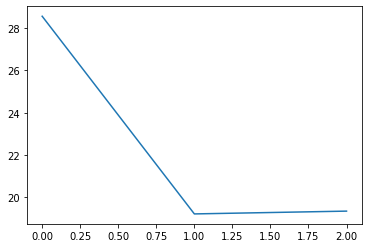

window_2


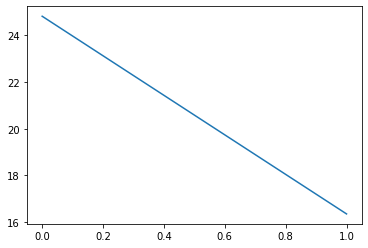

window_3


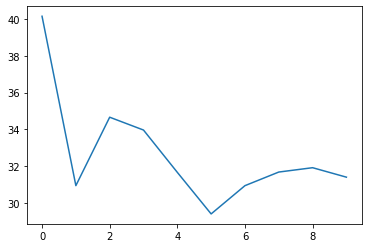

window_4


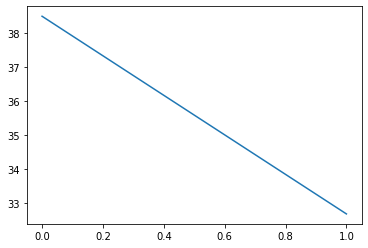

window_5


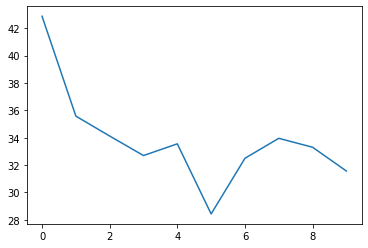

window_6


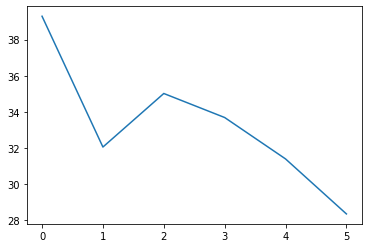

window_7


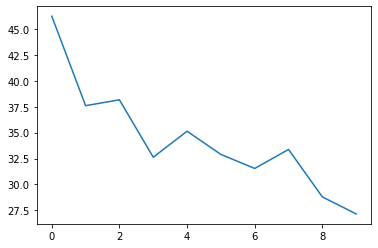

window_8


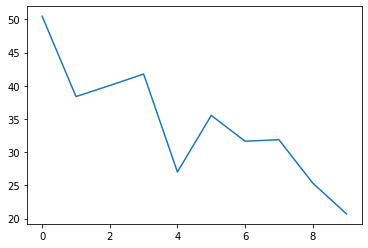

window_9


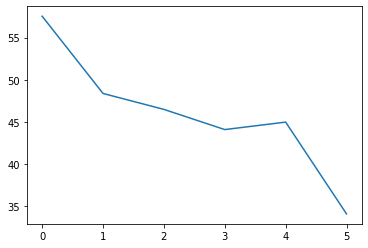

window_10


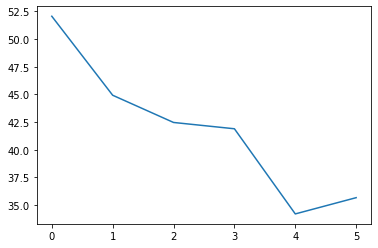

window_11


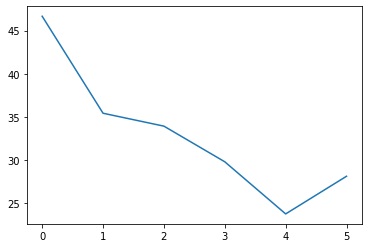

window_12


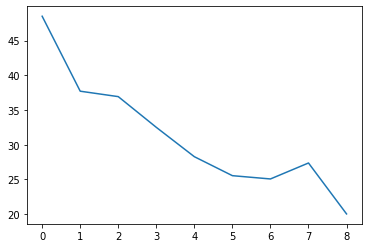

window_13


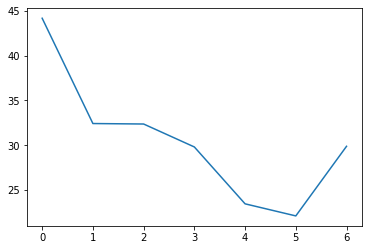

window_14


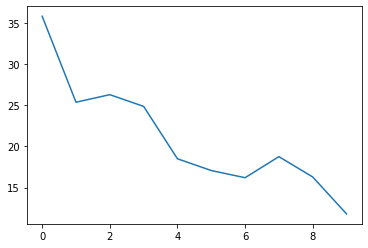

window_15


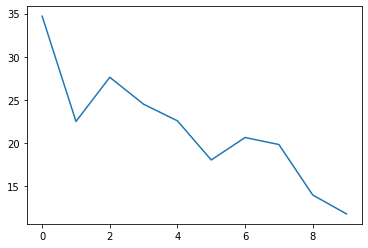

window_16


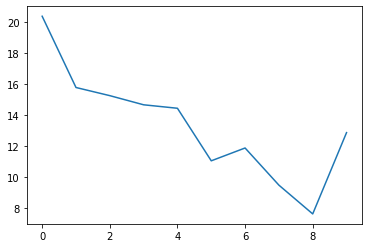

window_17


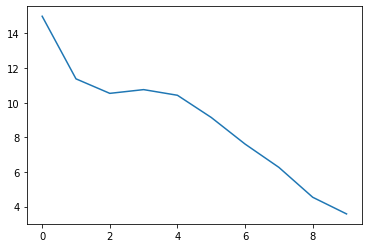

window_18


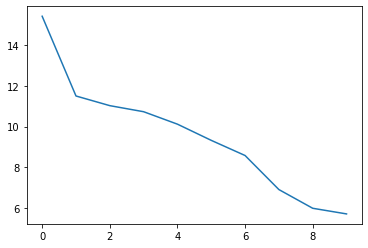

window_19


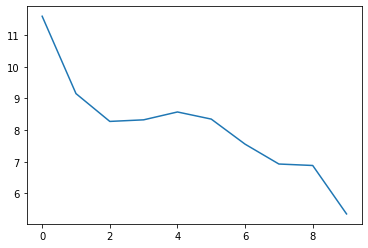

window_20


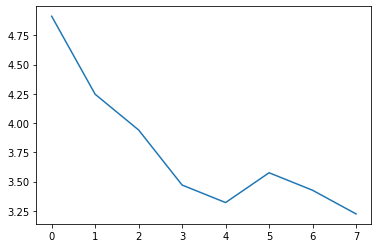

window_21


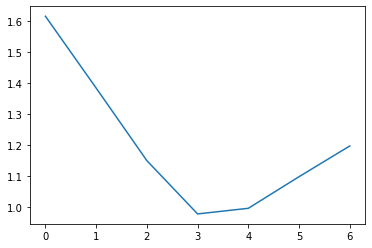

window_22


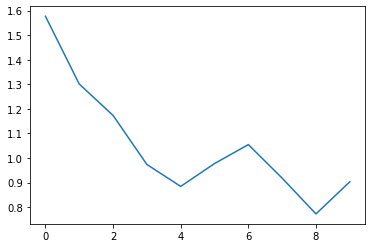

window_23


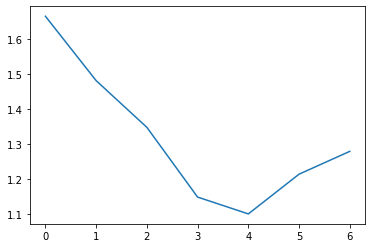

window_24


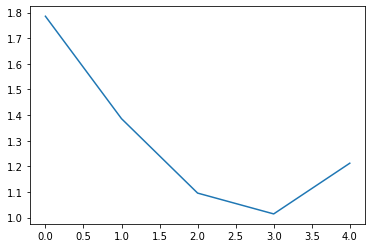

window_25


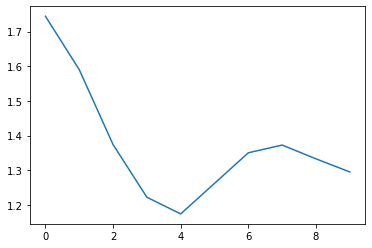

window_26


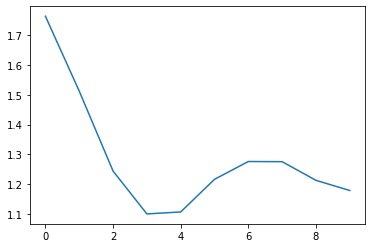

window_27


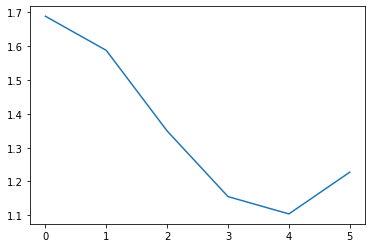

window_28


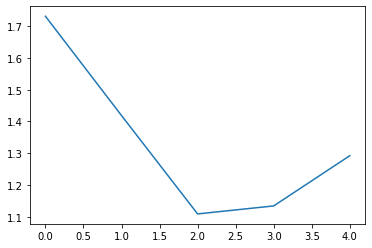

window_29


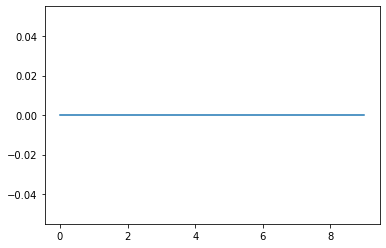

window_30


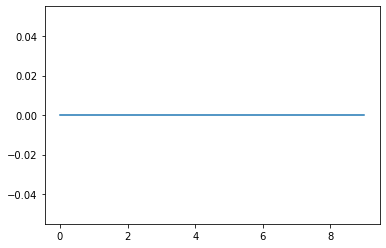

window_31


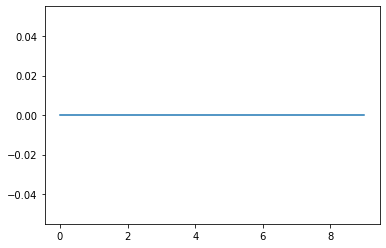

window_32


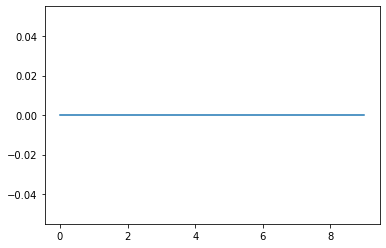

window_33


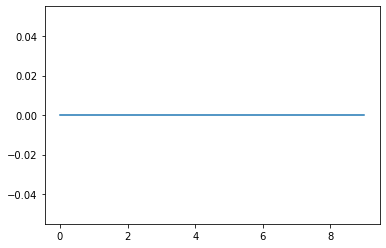

In [174]:
pw_window = training_window.prefix_wise_window()
cross_entropy_loss = torch.nn.CrossEntropyLoss()
for x in pw_window:
    print(x)
    input_x = pw_window[x][0]
    input_y = pw_window[x][1]
    dataset = pw_window[x]
    train_x,train_y = Customdataset(dataset).preprocessing()
    loss_list =[]
    
    x_tensor = torch.unsqueeze(train_x[0], dim=0)
    y_tensor = torch.unsqueeze(train_y[0], dim=0)
    model = LSTM_model(x_tensor, input_y)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer.zero_grad()

    previous_model =0
    for i in range(10):
        running_loss =0
        for pos, x in enumerate(train_x):
            x_tensor = torch.unsqueeze(x, dim=0)
            y_tensor = torch.unsqueeze(train_y[pos], dim=0)
                
            output = model(x_tensor)
            loss = cross_entropy_loss(output, y_tensor)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        

        if len(loss_list) ==0:
            pass
        
        else:
            if running_loss > np.mean(loss_list):
                break
    
        loss_list.append(running_loss)
        previous_model = model
    plt.plot(loss_list)
    plt.show()
#     print('----------')